In this notebook, we will try to train a Decision-Tree model using permissions from 4287 benign and 3876 malicious android applications.

<h1>Loading Data</h1>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [13]:
permissions_df = pd.read_csv('../catch-o-extractor/extracted_permissions.csv')
labeled_data_df = pd.read_csv('../catch-o-labeler/labeled_data.csv')

permissions_df = permissions_df.drop(permissions_df.columns[1], axis=1)
permissions_df = permissions_df.rename(columns={permissions_df.columns[0]: 'name'})

In [14]:
df = permissions_df.merge(labeled_data_df, left_on='name', right_on='hash', how='left')

df['detection'] = df['detection'].fillna('benign')

df = df.drop(columns=['hash'])


<h1>Regular Run Start</h1>
Up from here, you can find the necessary code to prepare the data to train.
For convenience, here on out we will use the already exported data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Read the CSV file
df = pd.read_csv('permissions_labeled_dataset.csv')
df

,name,ANDROID.PERMISSION.READ_EXTERNAL_STORAGE,ANDROID.PERMISSION.READ_PHONE_STATE,Android.permission.CALL_PHONE,Android.permission.CHANGE_CONFIGURATION,Android.permission.SYSTEM_ALERT_WINDOW,FULLSCREEN.FULL,Intent.FLAG_GRANT_READ_URI_PERMISSION,Intent.FLAG_GRANT_WRITE_URI_PERMISSION,MediaStore.Images.Media.EXTERNAL_CONTENT_URI,...,zoiwdzml.vynuw.glhpqs,zqzulr.ltqc.zwilnr,zrvfolm.cjlt.ewrs,zugwl.kbkmzb.vzvzm,zvayo.qwkucvn.gejbbw,zwbp.eejtyc.geukpacr,zxjz.brwvdng.lhoiw,zytit.fqntnjmm.bazaeag,zzag.otkdp.lvntgqsd,detection
0,org.microg.nlp.backend.ichnaea_20036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
1,net.casimirlab.frigoligo_34,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
2,by.yauhenl.gardine_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
3,org.mult.daap_51,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
4,com.falconware.prestissimo_11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21462,bf0f284c1ec994606bebe7c2e713f5b2e789a8a9ae8799...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,trojan
21463,0f6a8d3f76e60fc1561a2f69761e328e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,trojan
21464,db2d8008dd39b02e5731c435e5fda10e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,adware
21465,da3fdd06b7c6b3099905e46de98af328,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [2]:
df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'rootkit']
df = df[df['detection'] != 'other']

benign_samples = df[df['detection'] == 'benign'].sample(n=1000, replace=True)
other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop=True)
df = pd.concat([benign_samples, other_samples]).reset_index(drop=True)
df['detection'].value_counts()

/tmp/ipykernel_194638/2932402478.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop=True)


detection
benign      1000
adware       200
exploit      200
hacktool     200
spyware      200
trojan       200
Name: count, dtype: int64

In [3]:
# Separate features and labels
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h1>Training the Decision Tree Classifier</h1>

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

<h1>Evaluate the Model</h1>

In [6]:
y_pred = clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.8575
              precision    recall  f1-score   support

      adware       0.58      0.76      0.66        34
      benign       0.97      0.93      0.95       199
     exploit       0.68      0.85      0.76        33
    hacktool       0.93      0.89      0.91        44
     spyware       0.88      0.73      0.80        48
      trojan       0.72      0.69      0.71        42

    accuracy                           0.86       400
   macro avg       0.79      0.81      0.80       400
weighted avg       0.87      0.86      0.86       400



In [8]:
unique_classes = ['adware', 'benign', 'exploit', 'hacktool', 'spyware', 'trojan']

print(unique_classes)

['adware', 'benign', 'exploit', 'hacktool', 'spyware', 'trojan']


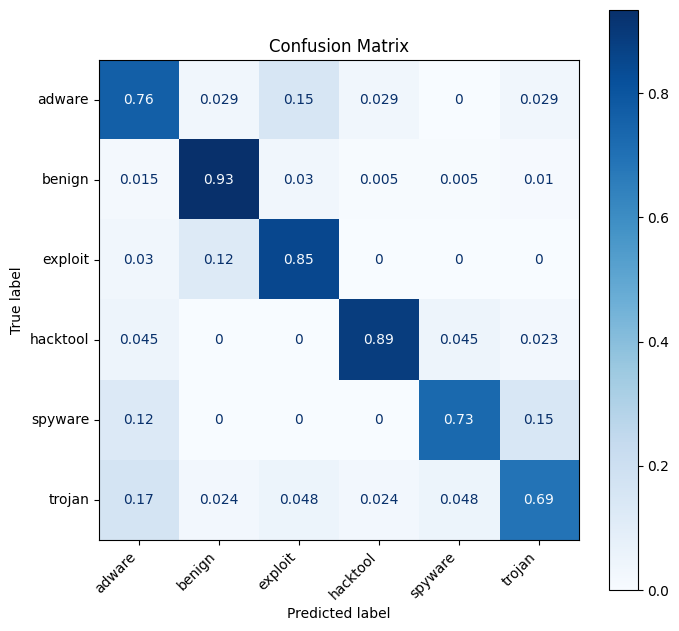

In [9]:
# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=unique_classes, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()

<h1>Hyper-Parameter Tuning</h1>

In [10]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Use StratifiedKFold to ensure each fold has a proportional representation of each class
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, verbose=2)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f'Best Parameters: {grid_search.best_params_}')


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.7s[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.7s

[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, m

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns


best_params= grid_search.best_params_
# Fit the decision tree model with optimal parameters
dt_optimal = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
dt_optimal.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_optimal.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the optimal decision tree model: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy of the optimal decision tree model: 0.8625

Classification Report:
              precision    recall  f1-score   support

      adware       0.59      0.76      0.67        34
      benign       0.95      0.96      0.95       199
     exploit       0.77      0.82      0.79        33
    hacktool       0.95      0.89      0.92        44
     spyware       0.85      0.73      0.79        48
      trojan       0.71      0.64      0.68        42

    accuracy                           0.86       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.87      0.86      0.86       400



NameError: name 'confusion_matrix' is not defined

<h1>Tree Visualization</h1>

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to a dot file
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X.columns,  
                           class_names=clf.classes_.astype(str),
                           filled=True, rounded=True,  
                           special_characters=True)  

# Use graphviz to render the dot file
graph = graphviz.Source(dot_data)  
graph.render("decision_tree")  # Saves the visualization to a file

# To visualize it directly in Jupyter Notebook (if using)
graph.view()


AttributeError: 'DecisionTreeClassifier' object has no attribute 'classes_'